In [1]:
import datetime
import re
import os
import urllib.parse

import dotenv
import findspark
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, functions as F, types as T

In [2]:
fields = ('host', 'ident', 'user', 'timestamp', 'request', 'status', 'size', 'referer', 'user_agent', 'x_forwarded_for')
TS_FORMAT = '%d/%b/%Y:%H:%M:%S %z'
dotenv.load_dotenv()


@F.udf(returnType=T.ArrayType(T.StringType()))
def tokenize_apache_log(line):
    tokens = list(map(''.join, re.findall(r'\"(.*?)\"|\[(.*?)\]|(\S+)', line)))
    return tokens


@F.udf(returnType=T.StringType())
def url_decode(value):
    return urllib.parse.unquote(value)


@F.udf(returnType=T.LongType())
def epoch(value):
    return int(
        datetime.datetime.strptime(
            value,
            TS_FORMAT
        ).astimezone(
            datetime.timezone.utc
        ).timestamp()
    )

In [3]:
findspark.init(os.getenv('SPARK_HOME'))

In [4]:
spark = SparkSession.builder.config(
    conf=SparkConf().setAppName('data-analysis')
).getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
df = spark.read.format('text').load('/user/k0rtuz/data/access.log').withColumnRenamed('value', 'raw')
df.show(10, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                 raw|
+----------------------------------------------------------------------------------------------------+
|54.36.149.41 - - [22/Jan/2019:03:56:14 +0330] "GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...|
|31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/60844/productModel/200x200 HTTP/1.1" 200...|
|31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] "GET /image/61474/productModel/200x200 HTTP/1.1" 200...|
|40.77.167.129 - - [22/Jan/2019:03:56:17 +0330] "GET /image/14925/productModel/100x100 HTTP/1.1" 2...|
|91.99.72.15 - - [22/Jan/2019:03:56:17 +0330] "GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%D...|
|40.77.167.129 - - [22/Jan/2019:03:56:17 +0330] "GET /image/23488/productModel/150x150 HTTP/1.1" 2...|
|40.77.167.129 - - [22/Jan/2019:03:56:18 +0330] "GET /image/45437/product

In [6]:
total = df.count()

In [7]:
print(f'Total records: {total}')

Total records: 10365152


In [8]:
df = df.withColumn(
    'id', F.monotonically_increasing_id()
).withColumn(
    'values', tokenize_apache_log(F.col('raw'))
).select(
    [F.col('id')] + [(F.col('values')[k]).alias(field) for k, field in enumerate(fields)]
)

for key in fields:
    df = df.withColumn(key, F.when(F.col(key).isin('-', '"-"'), None).otherwise(F.col(key)))

In [9]:
df.printSchema()

root
 |-- id: long (nullable = false)
 |-- host: string (nullable = true)
 |-- ident: string (nullable = true)
 |-- user: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- request: string (nullable = true)
 |-- status: string (nullable = true)
 |-- size: string (nullable = true)
 |-- referer: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- x_forwarded_for: string (nullable = true)



In [10]:
df.select([F.round(100 * F.count(F.when(F.isnull(c), c)) / total, 3).alias(c) for c in df.columns]).show()

+---+----+-----+-----+---------+-------+------+----+-------+----------+---------------+
| id|host|ident| user|timestamp|request|status|size|referer|user_agent|x_forwarded_for|
+---+----+-----+-----+---------+-------+------+----+-------+----------+---------------+
|0.0| 0.0|100.0|100.0|      0.0|    0.0|   0.0| 0.0| 15.884|      0.14|         99.768|
+---+----+-----+-----+---------+-------+------+----+-------+----------+---------------+



In [11]:
df = df.drop('ident', 'user', 'x_forwarded_for')

In [12]:
fields = ('id', 'host', 'timestamp', 'method', 'path', 'status', 'size', 'user_agent')
df = df.withColumn(
    'timestamp', epoch(F.col('timestamp'))
).withColumn(
    'request', F.split(F.col('request'), ' ')
).withColumn(
    'method', F.col('request')[0]
).withColumn(
    'path', F.col('request')[1]
).drop(
    'request'
).withColumn(
    'status', F.col('status').astype(T.ShortType())
).withColumn(
    'size', F.col('size').astype(T.LongType())
).select(*fields)

In [13]:
df.printSchema()

root
 |-- id: long (nullable = false)
 |-- host: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- method: string (nullable = true)
 |-- path: string (nullable = true)
 |-- status: short (nullable = true)
 |-- size: long (nullable = true)
 |-- user_agent: string (nullable = true)



In [14]:
df.write.format('parquet').save('/user/k0rtuz/transformed/apache_access_logs.parquet')

In [15]:
df2 = spark.read.format('parquet').load('/user/k0rtuz/transformed/apache_access_logs.parquet')

In [16]:
df2.groupby(F.col('method')).agg(
    F.count(F.col('id')).alias('count')
).withColumn(
    'perc', F.round(100 * F.col('count') / total, 3)
).sort(
    F.col('count').desc()
).select('method', 'count', 'perc').show()

+--------------------+--------+-----+
|              method|   count| perc|
+--------------------+--------+-----+
|                 GET|10190005|98.31|
|                POST|  139155|1.343|
|                HEAD|   34501|0.333|
|             OPTIONS|    1424|0.014|
|             CONNECT|      10|  0.0|
|                    |       7|  0.0|
|                   G|       5|  0.0|
|            PROPFIND|       3|  0.0|
|\x04\x01\x00P\x05...|       2|  0.0|
|\x16\x03\x01\x00^...|       2|  0.0|
|\x03\x00\x00/*\xE...|       2|  0.0|
|\x15\x03\x01\x00\...|       2|  0.0|
|                  t3|       2|  0.0|
|        \x05\x01\x00|       2|  0.0|
|\x17\x10\x05\x15J...|       1|  0.0|
|E\x00\x00J\x11,@\...|       1|  0.0|
|\x17\x03\x03\x01\...|       1|  0.0|
|\x03\x01\x02\x00\...|       1|  0.0|
|\x16\x03\x01\x00^...|       1|  0.0|
|\x16\x03\x01\x00\...|       1|  0.0|
+--------------------+--------+-----+
only showing top 20 rows



In [17]:
@F.udf(returnType=T.ArrayType(T.LongType()))
def separations(values):
    if len(values) < 2:
        seps = []
    else:
        values.sort()
        seps = [(end - start) for start, end in zip(values[:-1], values[1:])]

    return seps

In [18]:
df2 = df2.groupby(
    F.col('host')
).agg(
    F.count(F.col('id')).alias('count'),
    F.collect_list(F.col('timestamp')).alias('ts')
).withColumn(
    'separations', separations(F.col('ts'))
).sort(
    F.col('count').desc()
).select('host', 'count', 'separations')

In [21]:
df2.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df2.columns]).show()

2021-12-24 00:37:29,916 ERROR cluster.YarnScheduler: Lost executor 1 on secdev: Container from a bad node: container_1640274129738_0001_01_000002 on host: secdev. Exit status: 137. Diagnostics: [2021-12-24 00:37:29.477]Container killed on request. Exit code is 137
[2021-12-24 00:37:29.479]Container exited with a non-zero exit code 137. 
[2021-12-24 00:37:29.480]Killed by external signal
.


+----+-----+-----------+
|host|count|separations|
+----+-----+-----------+
|   0|    0|          0|
+----+-----+-----------+



In [ ]:
ds = df2.toPandas()
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(ds['count'], 100)
plt.show()

2021-12-24 00:38:32,423 ERROR cluster.YarnScheduler: Lost executor 3 on secdev: Container from a bad node: container_1640274129738_0001_01_000004 on host: secdev. Exit status: 137. Diagnostics: [2021-12-24 00:38:32.314]Container killed on request. Exit code is 137
[2021-12-24 00:38:32.316]Container exited with a non-zero exit code 137. 
[2021-12-24 00:38:32.317]Killed by external signal
.
2021-12-24 00:38:42,066 ERROR client.TransportClient: Failed to send RPC RPC 7292985338970791326 to /10.0.2.15:40584: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source)
2021-12-24 00:38:42,076 ERROR cluster.YarnScheduler: Lost executor 4 on secdev: Executor Process Lost


In [24]:
total_hosts = df2.count()
df2.groupby(
    F.col('count')
).agg(
    F.count(F.col('host')).alias('num_hosts')
).withColumn(
    'perc', F.round(100 * F.col('num_hosts') / total_hosts, 3)
).sort(
    F.col('perc').desc()
).select('count', 'num_hosts', 'perc').show()

+-----+---------+------+
|count|num_hosts|  perc|
+-----+---------+------+
|    1|    93501|36.156|
|    2|    26724|10.334|
|    3|    12296| 4.755|
|    4|     7332| 2.835|
|    5|     4001| 1.547|
|   11|     3399| 1.314|
|    6|     3136| 1.213|
|   15|     2984| 1.154|
|   12|     2581| 0.998|
|    7|     2480| 0.959|
|    8|     2092| 0.809|
|   13|     1979| 0.765|
|   34|     1888|  0.73|
|   33|     1869| 0.723|
|   14|     1862|  0.72|
|   10|     1800| 0.696|
|    9|     1787| 0.691|
|   22|     1762| 0.681|
|   16|     1706|  0.66|
|   20|     1700| 0.657|
+-----+---------+------+
only showing top 20 rows



In [13]:
@F.udf(returnType=T.FloatType())
def median(values):
    if len(values) == 0:
        med = None
    elif len(values) == 1:
        med = values[0]
    else:
        med = np.median(np.asarray(values)).item()
    
    return med


@F.udf(returnType=T.FloatType())
def std(values):
    if len(values) == 0:
        result = None
    elif len(values) == 1:
        result = values[0]
    else:
        result = np.std(np.asarray(values)).item()
    
    return result


@F.udf(returnType=T.FloatType())
def safe_log(value):
    if value is None:
        result = None
    elif value <= 0:
        result = -50
    else:
        result = np.log10(np.asarray(value)).item()

    return result

In [14]:
df3 = df2.withColumn(
    'med_sep', median(F.col('separations'))
).withColumn(
    'std_sep', std(F.col('separations'))
).withColumn(
    'log_count', safe_log(F.col('count'))
).withColumn(
    'log_med_sep', safe_log(F.col('med_sep'))
).withColumn(
    'log_std_sep', safe_log(F.col('std_sep'))
).sort(
    F.col('count').desc()
).select('host', 'log_count', 'log_med_sep', 'log_std_sep')

In [66]:
df3.select([
    F.round(
        100 * F.count(F.when(F.isnull(c), c)) / total_hosts, 3
    ).alias(c) for c in df3.columns
]).show()

+----+---------+-----------+-----------+
|host|log_count|log_med_sep|log_std_sep|
+----+---------+-----------+-----------+
| 0.0|      0.0|     73.893|     38.619|
+----+---------+-----------+-----------+



In [15]:
df3.write.format('parquet').save('/user/k0rtuz/transformed/log_stats.parquet')

In [16]:
df3 = spark.read.format('parquet').load('/user/k0rtuz/transformed/log_stats.parquet')

In [17]:
ds = df3.toPandas()

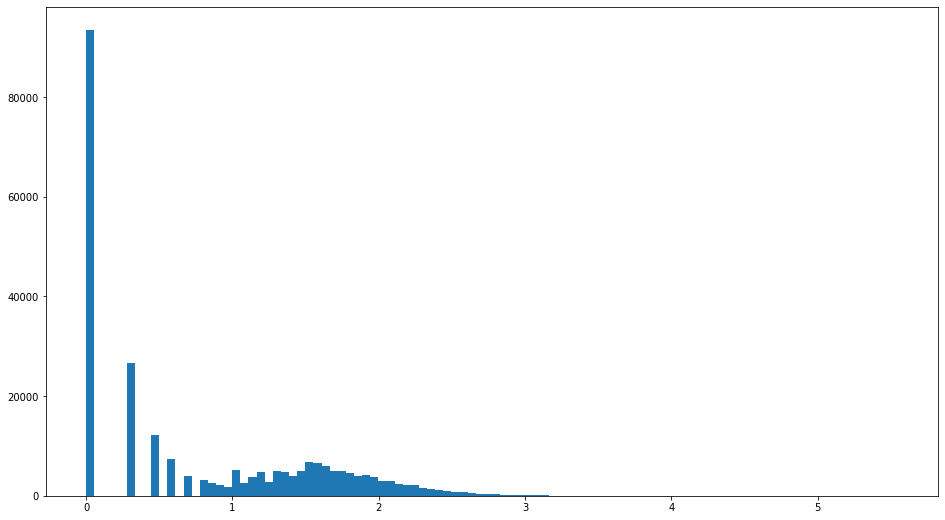

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(ds['log_count'], 100)
plt.show()

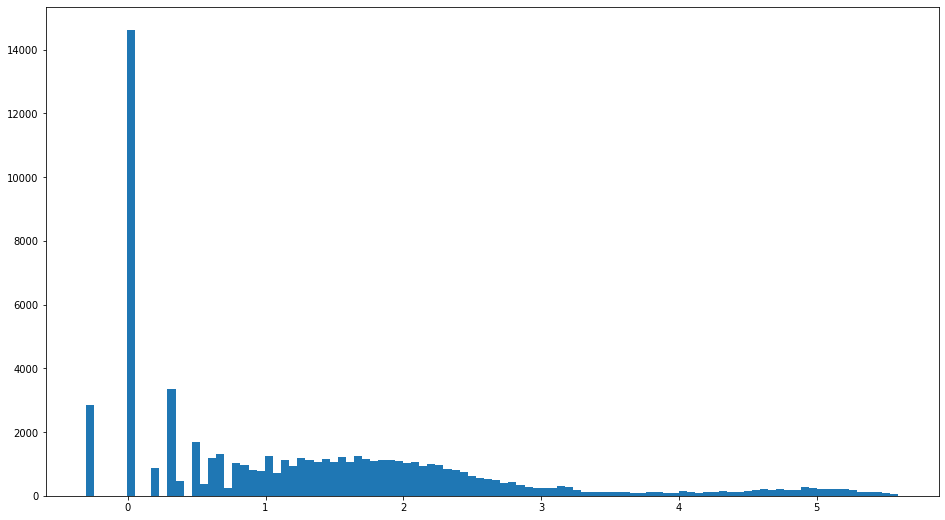

In [19]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(ds['log_med_sep'], 100)
plt.show()

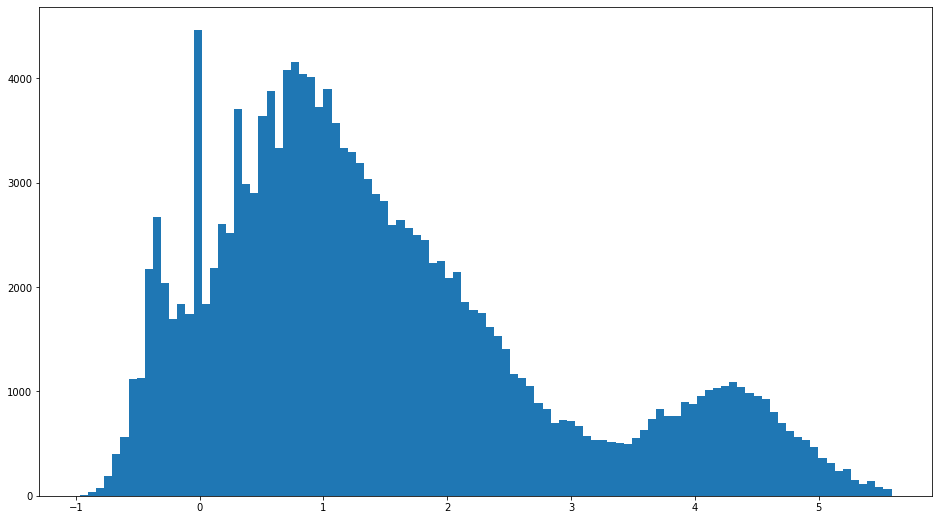

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(ds['log_std_sep'], 100)
plt.show()

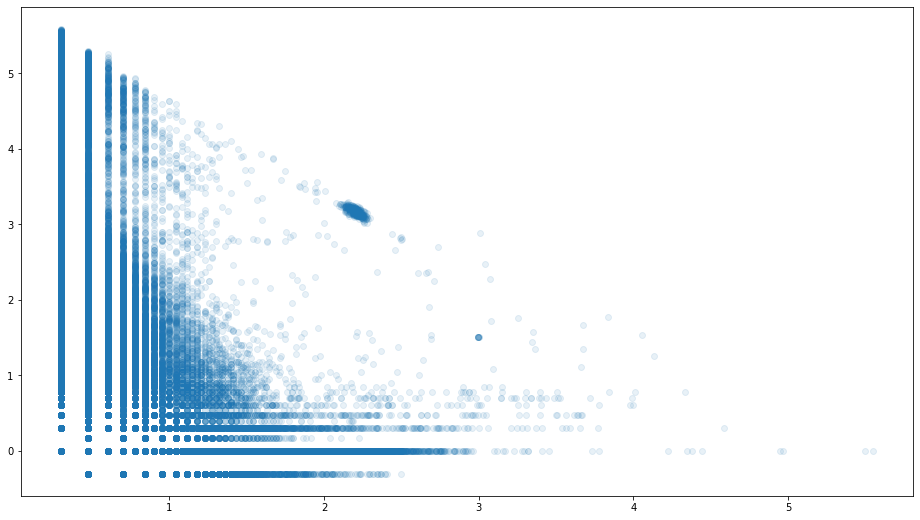

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(ds['log_count'], ds['log_med_sep'], alpha=0.1)
plt.show()

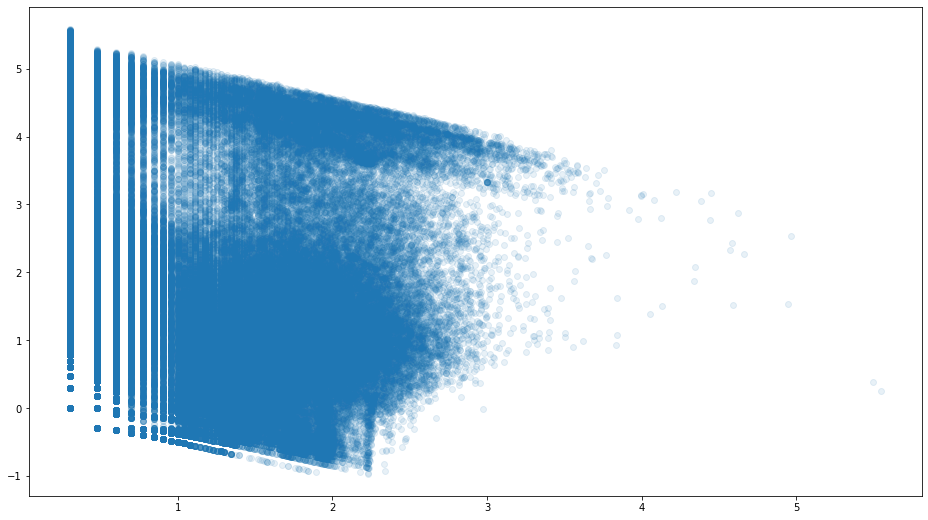

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(ds['log_count'], ds['log_std_sep'], alpha=0.1)
plt.show()

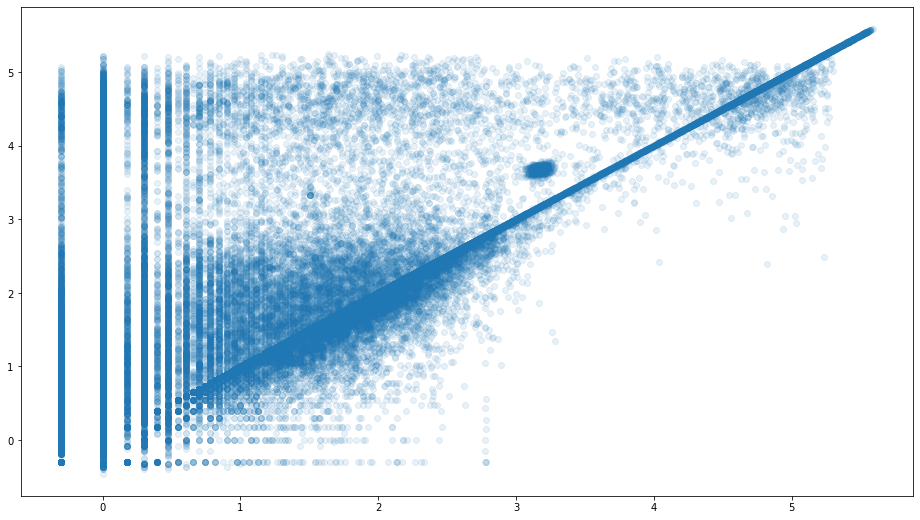

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(ds['log_med_sep'], ds['log_std_sep'], alpha=0.1)
plt.show()